# Network Builder

## Description
Build the semantic network from clean Reddit posts' and comments.

## Setup

### Libraries (Pyhton)

In [51]:
import igraph as ig
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import sys
import time
import umap

### Directories

In [2]:
try:
    BASE_DIR = Path(__file__).resolve().parent
except NameError:
    BASE_DIR = Path().resolve()

SRC_DIR = BASE_DIR / 'src'
if str(SRC_DIR) not in sys.path:
    sys.path.append(str(SRC_DIR))

DATA_DIR = BASE_DIR / 'data'
DATA_DIR.mkdir(exist_ok=True)
POSTS_DIR = DATA_DIR / 'posts'
POSTS_ALL_DIR = POSTS_DIR / 'all'
POSTS_FILTERED_DIR = POSTS_DIR / 'filtered'
POSTS_FILTERED_CLEAN_DIR = POSTS_FILTERED_DIR / 'clean'
COMMENTS_DIR = DATA_DIR / 'comments'
COMMENTS_CLEAN_DIR = COMMENTS_DIR / 'clean'
RESULTS_DIR = BASE_DIR / 'results'
RESULTS_GRAPHS_DIR = RESULTS_DIR / 'graphs'

### Libraries (Custom)

In [44]:
import builder as bn
import ncp
import utils

## Import Data

In [4]:
filename_posts = POSTS_FILTERED_CLEAN_DIR / 'all_posts_clean.json'
filename_comments = COMMENTS_CLEAN_DIR / 'all_comments_clean.json'
posts = pd.read_json(filename_posts)
comments = pd.read_json(filename_comments)

## Build Bipartite Network

In [5]:
# --- Prep posts ---
df_posts = posts.copy()
df_posts['document_id'] = df_posts['id']
df_posts['root_post_id'] = df_posts['id']
df_posts['document_type'] = 'post'

# --- Prep comments ---
df_comments = comments.copy()
df_comments['document_id'] = df_comments['comment_id']
df_comments['root_post_id'] = df_comments['post_id']
df_comments['document_type'] = 'comment'

# --- Ensure the same columns exist in both ---
common_cols = list(set(df_posts.columns).intersection(set(df_comments.columns)))
df_merged = pd.concat([df_posts[common_cols], df_comments[common_cols]], ignore_index=True)

In [6]:
df_merged.to_json(DATA_DIR / 'data.json', orient='records', lines=True)

In [7]:
network = bn.BuildNetwork(df_merged, column='filtered_pos')
network.build(tfidf=True)

In [8]:
netowrk_bipartite = bn.to_igraph_bipartite(network, use='Pwd')
print(f"Bipartite graph has {netowrk_bipartite.vcount()} nodes and {netowrk_bipartite.ecount()} edges.")

Bipartite graph has 24588 nodes and 403574 edges.


### Analyze Degree Distribution

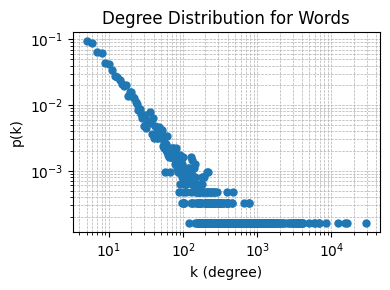

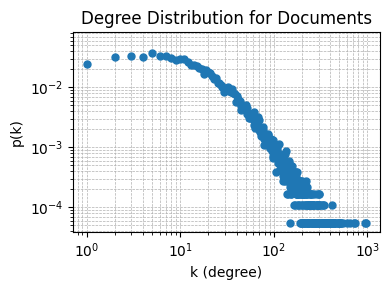

In [9]:
network.plot_degree_distribution(type='words')
network.plot_degree_distribution(type='documents')

--- Power-Law Analysis (words) ---
Gamma (scaling exponent): 2.0085
K_min (cutoff): 112.0


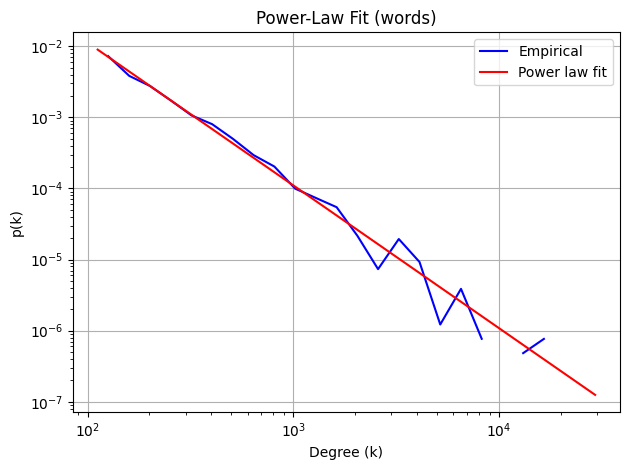

--- Power-Law Analysis (documents) ---
Gamma (scaling exponent): 3.9045
K_min (cutoff): 183.0


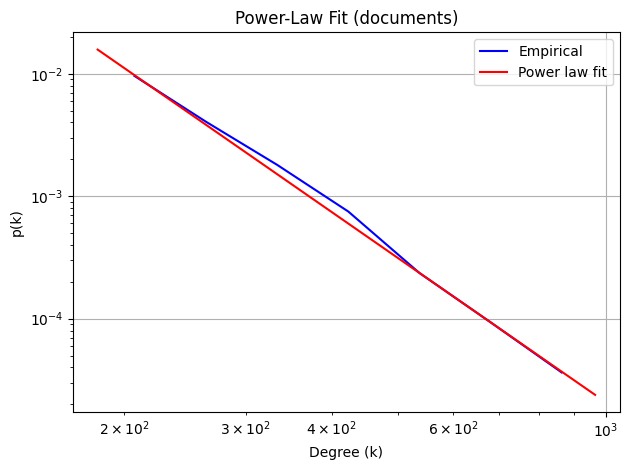

In [10]:
network.analyze_degree_distribution_powerlaw(type='words')
network.analyze_degree_distribution_powerlaw(type='documents')

## Build Projected Networks
Project the bipartite network onto words and documents.

### Word Projection

#### Network Community Profile
Use Local PageRank to calculate and plot the NCP.

In [11]:
word_projection = bn.to_igraph_projected(network, use='Pww', threshold=0.0)
print(f"Word-projected graph has {word_projection.vcount()} nodes and {word_projection.ecount()} edges.")

Word-projected graph has 6247 nodes and 2628289 edges.


In [12]:
# Create thresholded graphs
word_proj_90 = ncp.threshold_graph(word_projection, 90)
word_proj_95 = ncp.threshold_graph(word_projection, 95)
word_proj_99 = ncp.threshold_graph(word_projection, 99)

In [13]:
sizes = list(range(10, 1001, 50))
num_seeds = 10

In [14]:
# 90th percentile
start_time = time.time()
ncp_90 = ncp.compute_ncp(word_proj_90, sizes, num_seeds=num_seeds)
end_time = time.time()

print(f"NCP computed for {len(sizes)} sizes with {num_seeds} seeds in {end_time - start_time:.2f} seconds.")

NCP computed for 20 sizes with 10 seeds in 265.12 seconds.


In [15]:
# 95th percentile
start_time = time.time()
ncp_95 = ncp.compute_ncp(word_proj_95, sizes, num_seeds=num_seeds)
end_time = time.time()

print(f"NCP computed for {len(sizes)} sizes with {num_seeds} seeds in {end_time - start_time:.2f} seconds.")

NCP computed for 20 sizes with 10 seeds in 254.96 seconds.


In [16]:
# 99th percentile
start_time = time.time()
ncp_99 = ncp.compute_ncp(word_proj_99, sizes, num_seeds=num_seeds)
end_time = time.time()

print(f"NCP computed for {len(sizes)} sizes with {num_seeds} seeds in {end_time - start_time:.2f} seconds.")

NCP computed for 20 sizes with 10 seeds in 191.16 seconds.


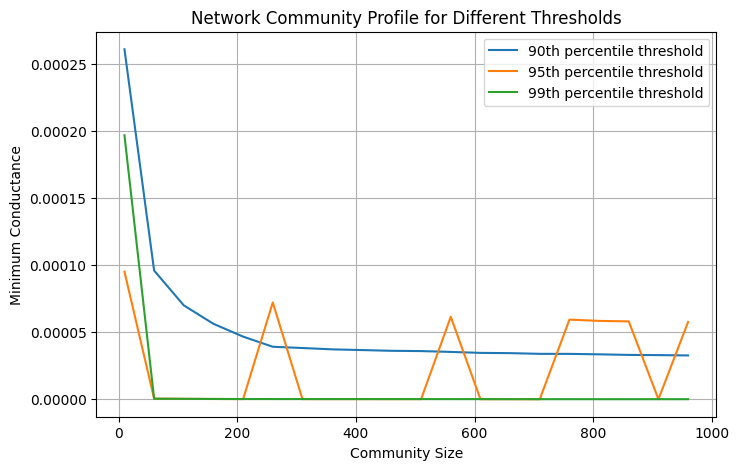

In [17]:
ncp.plot_ncp(ncp_90, ncp_95, ncp_99, sizes)

#### Build Network
Use 95th percentile threshold from NCP to build the WW graph.

In [19]:
print(f"Word-projected graph has {word_proj_95.vcount()} nodes and {word_proj_95.ecount()} edges.")
print(f"Graph is connected? {word_proj_95.is_connected()}.")

Word-projected graph has 6247 nodes and 131415 edges.
Graph is connected? False.


In [35]:
# Basic stats for full word-projected network
print("--- Word-Projected Network ---")
print(f"Average degree: {np.mean(word_proj_95.degree()):.2f}")
print(f"Median degree: {np.median(word_proj_95.degree()):.2f}")
print(f"Density: {word_proj_95.density():.5f}")
components_word = word_proj_95.connected_components()
print(f"Connected components: {len(components_word)}\n")

# Largest component
giant_component_word = components_word.giant()
print("--- Giant Component of Word-Projected Network ---")
print(f"Size of the giant component: {giant_component_word.vcount()}")
print(f"Average degree: {np.mean(giant_component_word.degree()):.2f}")
print(f"Median degree: {np.median(giant_component_word.degree()):.2f}")
print(f"Density: {giant_component_word.density():.5f}")

--- Word-Projected Network ---
Average degree: 42.07
Median degree: 6.00
Density: 0.00674
Connected components: 404

--- Giant Component of Word-Projected Network ---
Size of the giant component: 5843
Average degree: 44.98
Median degree: 7.00
Density: 0.00770


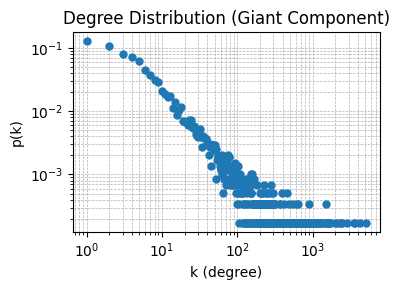

In [21]:
utils.plot_giant_component_degree_distribution(giant_component_word)

In [50]:
utils.plot_ccdf(giant_component_word)

AttributeError: module 'utils' has no attribute 'plot_ccdf'

c:\Users\mikae\Desktop\ns-project\venv\Lib\site-packages\sklearn\utils\deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
c:\Users\mikae\Desktop\ns-project\venv\Lib\site-packages\umap\umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


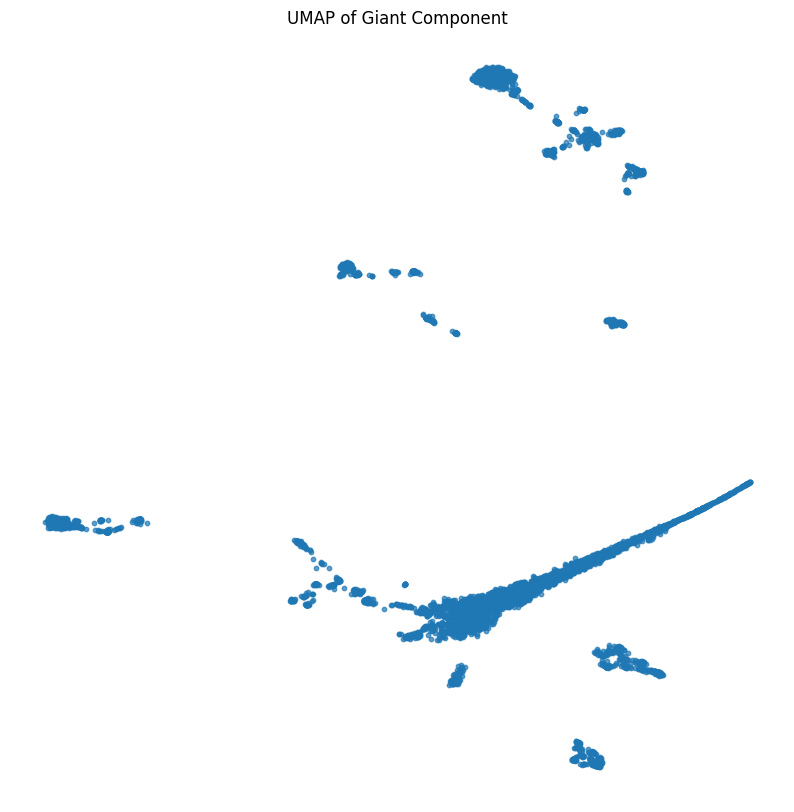

In [49]:
import matplotlib.pyplot as plt

# --- 1️⃣ Load / Build your graph ---
# Example:
# g = ig.Graph.Read_GraphML("your_graph.graphml")
# Or however you built it!


# --- 2️⃣ Adjacency matrix of the giant component ---
# Convert to dense numpy array
adj_matrix_giant_word = np.array(giant_component_word.get_adjacency().data, dtype=float)

# --- 3️⃣ Compute UMAP embedding ---
# You can tweak n_neighbors, min_dist, and other parameters
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embedding = reducer.fit_transform(adj_matrix_giant_word)

# --- 4️⃣ Plot ---
plt.figure(figsize=(10, 10))
plt.scatter(
    embedding[:, 0], embedding[:, 1],
    s=10, alpha=0.7
    )
plt.title('UMAP of Giant Component')
plt.axis('off')
plt.show()

### Document Projection

#### Network Community Profile
Use Local PageRank to calculate and plot the NCP.

In [52]:
docs_projection = bn.to_igraph_projected(network, use='Pdd', threshold=0.0)
print(f"Word-projected graph has {docs_projection.vcount()} nodes and {docs_projection.ecount()} edges.")

MemoryError: 

In [ ]:
# Create thresholded graphs
docs_proj_90 = ncp.threshold_graph(docs_projection, 90)
docs_proj_95 = ncp.threshold_graph(docs_projection, 95)
docs_proj_99 = ncp.threshold_graph(docs_projection, 99)

In [ ]:
sizes = list(range(10, 1001, 50))
num_seeds = 10

In [ ]:
# 90th percentile
start_time = time.time()
ncp_90_docs = ncp.compute_ncp(docs_proj_90, sizes, num_seeds=num_seeds)
end_time = time.time()

print(f"NCP computed for {len(sizes)} sizes with {num_seeds} seeds in {end_time - start_time:.2f} seconds.")

## Save to .gexf

In [31]:
filename_b = RESULTS_GRAPHS_DIR / 'g_wd.graphml'
netowrk_bipartite.write_graphml(str(filename_b))

In [30]:
filename_w = RESULTS_GRAPHS_DIR / 'g_ww.graphml'
giant_component_word.write_graphml(str(filename_w))

In [ ]:
filename_d = RESULTS_GRAPHS_DIR / 'g_dd.graphml'
giant_component_docs.write_graphml(filename_d)